In [1]:
%matplotlib inline

In [9]:
import numpy as np
import pylab as pl
from pydelay import dde23

eqns = { 
    'x' : 'beta * x(t-tau) / (1.0 + pow(x(t-tau),n)) -gamma*x' 
    }

params1 = {
    'beta'  : 0.2,
    'tau'   : 44,
    'n'     : 10.0,
    'gamma' : 0.1
    }

dde = dde23(eqns=eqns, params=params1)

Nt = 2000
dt = 0.5
N = 20000

N += Nt
tf = N*dt+515

dde.set_sim_params(tfinal=tf, dtmax=1)

histfunc = {
    'x': lambda t: 0.5
    } 
dde.hist_from_funcs(histfunc, 51)

dde.run()

sol1 = dde.sample(515, tf, dt)
x1 = sol1['x']

sol2 = dde.sample(500, tf-15, dt)
x2 = sol2['x']

pl.plot(x1, x2)
pl.xlabel('$x(t)$')
pl.ylabel('$x(t - 15)$')
pl.show()

ts = x1[Nt:]

ImportError: No module named pydelay

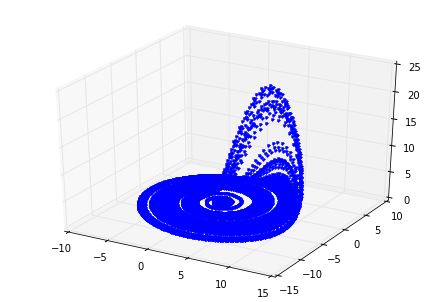

In [2]:
import numpy as np
import scipy.integrate as scpi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as p3

y0 = [0.1,0,0]

a = 0.2
b = 0.2
c = 5.7

def rossler(y,t):
    return [(-1*y[1]-y[2]), (y[0]+a*y[1]), (b+y[2]*(y[0]-c))]

rossxyz = scpi.odeint(rossler,y0,0.05*np.arange(10000))
    
fig = plt.figure()
ax = p3(fig)
ax.plot(rossxyz[:,0],rossxyz[:,1],rossxyz[:,2],'.')

ts = rossxyz[:,0]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.ckdtree import cKDTree
from scipy.stats import gmean

plt.ion()

class Attractor(object):
    def __init__(self,ts1,maxdel=100,s=False,autoc=10):
        self.tlen = len(ts1)
        self.ts = (np.array(ts1)-np.mean(ts1))/np.std(ts1)
        self.autoc = autoc
        self.data = self.ts.reshape(self.tlen,1)
        self.dim = 1
        self.G = None
        self.maxdel = maxdel
        self.lags = [0]
        self.betaStat = []

        self.Rtol = 10
        self.fnnarr = []

    def embed(self):
        self.dim = len(self.lags)
        mlag = max(self.lags)
        dlen = len(self.ts)-np.max(self.lags)
        self.data = np.empty((dlen,self.dim))
        for i in range(dlen):
            for j in range(self.dim):
                self.data[i,j] = self.ts[i+mlag-self.lags[j]]

    def nnGraph(self):
        self.G = nx.Graph()
        dlen = self.data.shape[0]
        tree = cKDTree(self.data) 
        for idx in range(dlen):
            self.G.add_node(idx)
        for i in range(dlen):
            x = self.data[i,:]
            nnb = tree.query(x,k=80)
            nnarr = zip(nnb[0],nnb[1])
            for t in nnarr[1:]:
                if abs(i-t[1]) > self.autoc and t[0] != 0.0:
                    self.G.add_edge(i,t[1],weight=t[0])
                    break

    def mdop(self,tau):
        s = []
        flsenn = 0
        dlen = self.data.shape[0]
        mlag = max(self.lags)
        for e in self.G.edges(data=True):
            if (e[0]+mlag-tau) >= 0 and (e[1]+mlag-tau) >= 0:
                d2 = abs(self.ts[e[0]+mlag-tau]-self.ts[e[1]+mlag-tau])
                if d2 != 0:
                    s.append((d2/e[2]['weight']))
                    if s[-1] > self.Rtol:
                        flsenn += 1
        NNF = float(flsenn)/len(s)
        return gmean(s), NNF

    def reconstruct(self):
        self.nnGraph()
        while True:
            lg = 0
            print "DOF %d"%(len(self.lags)+1)
            arr = []
            FNN = []
            for i in range(1,self.maxdel+1):
                ep, flsenn = self.mdop(i)
                print i, ep
                arr.append(ep)
                FNN.append(flsenn)

            tailc = len(arr)-1
            mxidx = tailc
            while True:
                mxidx = arr.index(max(arr[:tailc+1]))
                if mxidx == tailc:
                    tailc -= 1
                else:
                    break
            lg = mxidx+1
            
            lg1 = raw_input("choose (%d)-> "%lg)
            if lg1.strip():
                lg = int(lg1.strip())
            self.lags.append(lg)
            self.betaStat.append(arr[lg-1])
            self.fnnarr.append(FNN[lg-1])
            print "lag dof %d = %d"%(len(self.lags),lg)
            print "FNN =", self.fnnarr
            print "All lags ", ",".join([str(l) for l in self.lags])
            
            plt.plot(range(1,len(arr)+1),np.log10(arr),label="m = %d"%(self.dim+1))
            plt.plot([lg],[np.log10(arr[lg-1])],'ro',linewidth=4)
            plt.xlabel(r"Delays ($\tau$)",fontsize=10)
            plt.ylabel(r"$\log_{10}\beta_d(\tau)$",fontsize=10)
#             plt.ylabel(r"$\left<\log \phi'_d\right>$",fontsize=20)
            plt.xticks(fontsize=10)
            #plt.yticks(visible=False)
#             plt.legend()
#             plt.subplots_adjust(bottom=0.12)
            br = raw_input("-> ")
            if br.strip() == "b":
                break
            if self.fnnarr[-1] < 0.00000001:
               del self.lags[-1]
               break
            self.dim += 1
            self.embed()
            self.nnGraph()

DOF 2
1 286.218885011
2 570.578540711
3 852.273632301
4 1130.82247346
5 1404.28236357
6 1672.96763406
7 1932.45974652
8 2184.47196134
9 2436.14232346
10 2681.55449945
11 2911.47291279
12 3129.3048546
13 3336.14026659
14 3534.71965701
15 3723.09224927
16 3894.75986102
17 4067.0714626
18 4221.43391841
19 4337.5753281
20 4456.14703492
21 4577.01673329
22 4672.35157802
23 4744.24891357
24 4812.03313486
25 4851.10856411
26 4879.58697944
27 4882.13166353
28 4883.83130688
29 4887.48933563
30 4883.02688728
31 4856.92568546
32 4827.38277509
33 4794.3051709
34 4728.12072517
35 4665.15640695
36 4583.28270644
37 4512.12560485
38 4399.6494086
39 4274.16222645
40 4143.89976491
choose (29)-> 
lag dof 2 = 29
FNN = [0.9977514615499925]
All lags  0,29
-> 
DOF 3
1 0.578826055491
2 0.625071559319
3 0.658196569296
4 0.680432178221
5 0.698098579973
6 0.713103457915
7 0.73063745136
8 0.745139410542
9 0.756763521947
10 0.773204837117
11 0.788226222
12 0.798677871987
13 0.807908649049
14 0.816279390478
15 0.81

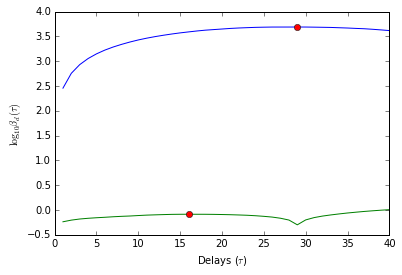

In [8]:
def rescale(x):
    xarr = np.copy(x)
    xarr -= np.min(x)
    xarr /= (np.max(x)-np.min(x))
    return xarr

attr = Attractor(rescale(ts),maxdel=40)
attr.reconstruct()

print "Embedding dimension =", len(attr.lags)
print ",".join([str(i) for i in attr.lags])